In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

### <font color=blue> Read in deaths df and acs df.

In [2]:
timestamp = '20241009-144131'

fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df_deaths = pd.read_csv(fpath)
# display(df)

## Drop rows with nans.
df_deaths.dropna(inplace=True)
# display(df)

## Drop samples with negative inc deaths.
df_deaths = df_deaths[df_deaths.True_inc_deaths >= 0]
# display(df_deaths)

# # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # 

from epsampling.utils import drop_duplicate_cols

# timestamp = '20241009-143022' 

fpath = os.path.join(DATA_DIR,'processed',f'formatted_acs_results_normed_{timestamp}.csv')
df_acs = pd.read_csv(fpath,index_col='Fips')

# Remove duplicate columns
df_acs = drop_duplicate_cols(df_acs)

### <font color=blue> Remove highly correlated features from acs df.

In [3]:
# ## Remove highly correlated features.

# corr_thresh = 0.9

# corr_matrix = df_acs.corr().abs()
# ## Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# ## Find features with correlation greater than like .99 ...
# to_drop = [column for column in upper.columns if any(upper[column] > corr_thresh)]
# ## Drop features 
# df_filt = df_acs.drop(to_drop, axis=1, inplace=False)
# df_acs = df_filt

### <font color=blue> Join naive deaths df with filtered acs df.

In [4]:
df = df_deaths.merge(df_acs, on='Fips')
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,HU_OCC,POP_NH,HINS_A0018,HINS_A65p,HH_x5,POP_A3564,HU_x14,POP_16p_EMP_x7,POP_A25p,POP_x2
0,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,0.904261,0.969522,0.979290,0.998043,21856.0,22690.0,24170.0,25871.0,39614.0,58239.0
1,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,0.904261,0.969522,0.979290,0.998043,21856.0,22690.0,24170.0,25871.0,39614.0,58239.0
2,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,0.904261,0.969522,0.979290,0.998043,21856.0,22690.0,24170.0,25871.0,39614.0,58239.0
3,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,0.904261,0.969522,0.979290,0.998043,21856.0,22690.0,24170.0,25871.0,39614.0,58239.0
4,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,0.904261,0.969522,0.979290,0.998043,21856.0,22690.0,24170.0,25871.0,39614.0,58239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304412,56045,56,6891.0,576641,0.011950,20220409,8.000000,18.0,18.0,0.0,...,0.802681,0.981425,0.844977,1.000000,2754.0,2724.0,3431.0,3044.0,4892.0,6891.0
304413,56045,56,6891.0,576641,0.011950,20220416,5.000000,18.0,18.0,0.0,...,0.802681,0.981425,0.844977,1.000000,2754.0,2724.0,3431.0,3044.0,4892.0,6891.0
304414,56045,56,6891.0,576641,0.011950,20220423,4.000000,18.0,18.0,0.0,...,0.802681,0.981425,0.844977,1.000000,2754.0,2724.0,3431.0,3044.0,4892.0,6891.0
304415,56045,56,6891.0,576641,0.011950,20220430,4.000000,18.0,18.0,0.0,...,0.802681,0.981425,0.844977,1.000000,2754.0,2724.0,3431.0,3044.0,4892.0,6891.0


### <font color=blue> Random forest.

In [5]:
def get_chunks(lst, n):
    """Return successive n-sized chunks from lst."""
    chunks = []
    for i in range(0, len(lst), n):
        chunks.append(lst[i:i + n])
    return chunks

In [6]:
chunks = get_chunks(list(df.Date.unique()), 4)

# idc = [2,10,18]
# idc = [10]

# for idx in idc:
    
idx = 18 #10

dates_test = chunks[idx]
dates_train = [x for x in df.Date.unique() if x not in dates_test]

df_train = df[df.Date.isin(dates_train)]
df_test = df[df.Date.isin(dates_test)]

feats = list(df_acs.columns) + ['Proj_inc_deaths','Cum_deaths_tm1','Naive_inc_deaths',
                               'State_pop','Ratio']

X_train = df_train[feats]
X_test = df_test[feats]

y_train = df_train['True_inc_deaths']
y_test = df_test['True_inc_deaths']

y_naive = df_test['Naive_inc_deaths']

In [7]:
from sklearn.ensemble import RandomForestRegressor
# train time for random split at 0.1 test_size? 2 min
clf = RandomForestRegressor(random_state=666, max_depth=6)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=666)

In [9]:
from epsampling.utils import get_performance

y_pred = clf.predict(X_test)

model_names = ['Deaths_pred', 'Deaths_naive']
model_preds = [y_pred, y_naive]

metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
metrics_dict

{'Deaths_pred': {'MAE': 1.7886590569407295,
  'MSE': 21.220972028684063,
  'RMSE': 4.606622627118925,
  'r2': 0.6261160996109685,
  'relMAE': 2.1420741648776427},
 'Deaths_naive': {'MAE': 1.837583513085075,
  'MSE': 23.064563374323328,
  'RMSE': 4.802558003223212,
  'r2': 0.5936345939523506,
  'relMAE': 1.0}}

In [9]:
importances = clf.feature_importances_
importances

array([0.000790, 0.000888, 0.000170, 0.000021, 0.000880, 0.000000,
       0.000103, 0.000143, 0.000168, 0.000767, 0.000050, 0.000185,
       0.000884, 0.000127, 0.000153, 0.001858, 0.000080, 0.000016,
       0.000280, 0.000595, 0.000049, 0.001172, 0.000071, 0.000963,
       0.000259, 0.000090, 0.000916, 0.000167, 0.000171, 0.000787,
       0.000913, 0.000306, 0.000178, 0.001273, 0.001319, 0.000143,
       0.000335, 0.000548, 0.003303, 0.000035, 0.000611, 0.000737,
       0.000692, 0.005101, 0.000179, 0.000227, 0.000049, 0.000719,
       0.000481, 0.000462, 0.000407, 0.000039, 0.000359, 0.000465,
       0.000306, 0.002957, 0.000576, 0.000849, 0.001104, 0.000630,
       0.001641, 0.000234, 0.001880, 0.001006, 0.000581, 0.000147,
       0.000225, 0.000267, 0.000418, 0.001925, 0.000292, 0.000523,
       0.000000, 0.000099, 0.000089, 0.000028, 0.000187, 0.003243,
       0.000523, 0.000054, 0.000203, 0.000757, 0.000133, 0.000945,
       0.000636, 0.000993, 0.000183, 0.000964, 0.000663, 0.000

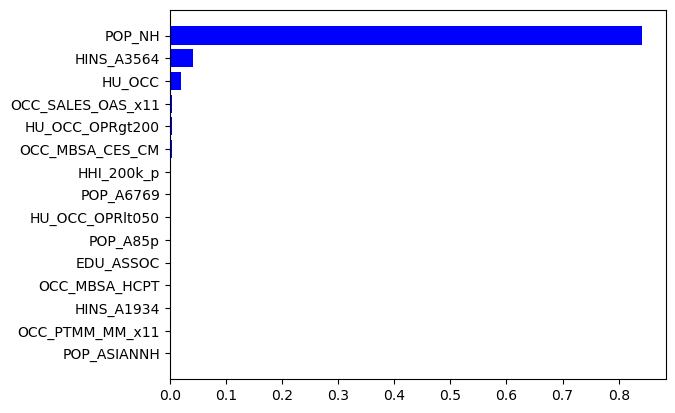

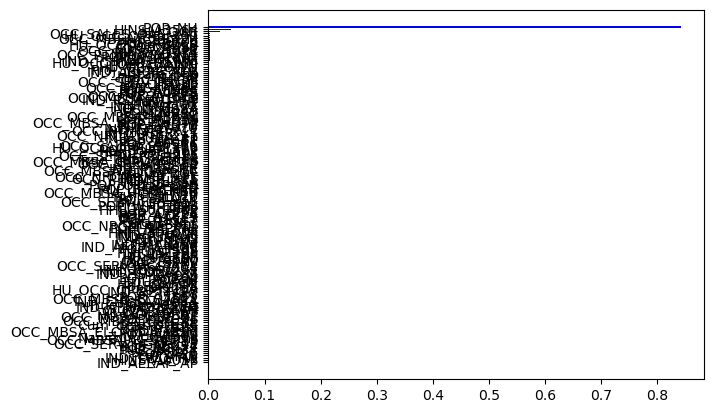

In [10]:
import matplotlib.pyplot as plt
import numpy as np

feats = df_train.columns.values
importances = clf.feature_importances_

indices = np.argsort(importances)[-15:]
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.show()

indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.show()

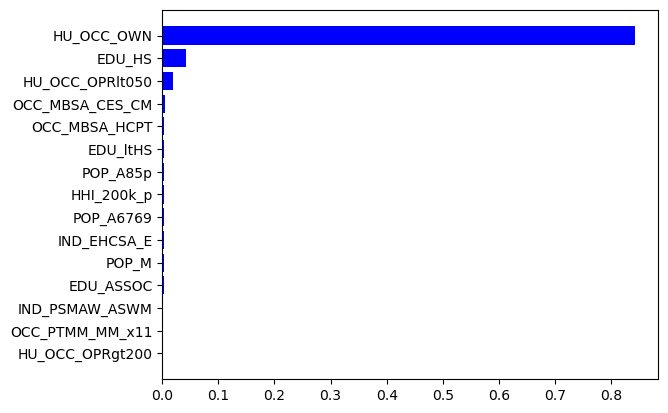

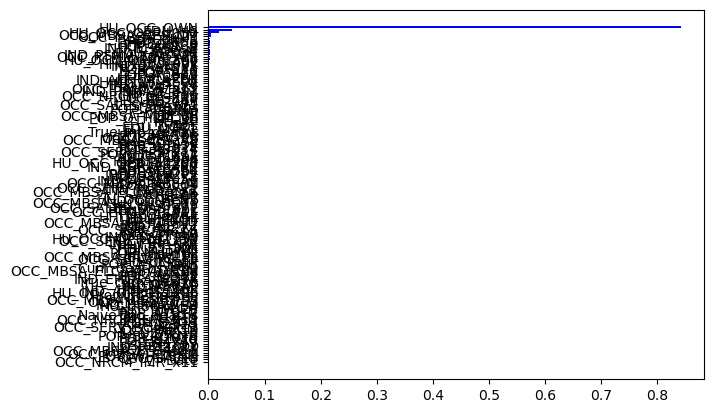

In [10]:
import matplotlib.pyplot as plt
import numpy as np

feats = df_train.columns.values
importances = clf.feature_importances_

indices = np.argsort(importances)[-15:]
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.show()

indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.show()